In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#starting with some ML we need to import some more packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# First Phase of Volatility Modeling

Started off with a simple dataset that contained a year of closing stock prices for the S&P500, the DJIA, Tesla, and Microsoft.

We then did some very simple volatility modeling here by calculating the returns over the data period and then using that to calculate historical volatility.

I then created a simple Linear Regression Model with the historical volatility and predicted what the last 50 days of the trading year would look like based on the initial 200 days of hard volatility data.

In [3]:
SP500 = pd.read_excel("startingstockdata.xlsx", sheet_name="SP500")

In [4]:
#To start we will import our data - four different datasets of different securities/investment vehicles
SP500 = pd.read_excel("startingstockdata.xlsx", sheet_name="SP500")
SP500 = SP500.drop(columns=['Date'])
DJIA = pd.read_excel("startingstockdata.xlsx", sheet_name="Dow Jones Industrial")
DJIA = DJIA.drop(columns=['Date'])
TSLA = pd.read_excel("startingstockdata.xlsx", sheet_name="Tesla")
TSLA= TSLA.drop(columns=['Date'])
MSFT = pd.read_excel("startingstockdata.xlsx", sheet_name="Microsoft")
MSFT = MSFT.drop(columns=['Date'])

#merge the sets into one
cols = [SP500, DJIA, TSLA, MSFT]
names = ["SP500", "DJIA", "TSLA", "MSFT"]
stocks = pd.concat(cols, axis=1)
stocks.columns = names
print(stocks)


       SP500      DJIA      TSLA     MSFT
0    6038.16  44726.99  389.0199  443.355
1    6067.70  44850.35  398.0900  447.200
2    6012.28  44713.58  397.1500  434.560
3    6101.24  44424.25  406.5800  444.060
4    6118.71  44565.07  412.3800  446.710
..       ...       ...       ...      ...
247  4958.61  38654.42  187.9100  411.220
248  4906.19  38519.84  188.8600  403.780
249  4845.65  38150.30  187.2900  397.580
250  4924.97  38467.31  191.5900  408.590
251  4927.93  38333.45  190.9300  409.720

[252 rows x 4 columns]


In [5]:
#Now we will begin to look into the volatility among these different securities
# To start we will look at the historical volatility among our datasets

#compute log returns
returns = np.log(stocks / stocks.shift(1))
#print(returns)

#compute rolling historical volatility (start with a 20-day window)
volatility = returns.rolling(window=20).std() * np.sqrt(252)

#This is just the standard deviation of past returns over the past x amount of days depending on the window
#so basically the distance from the mean

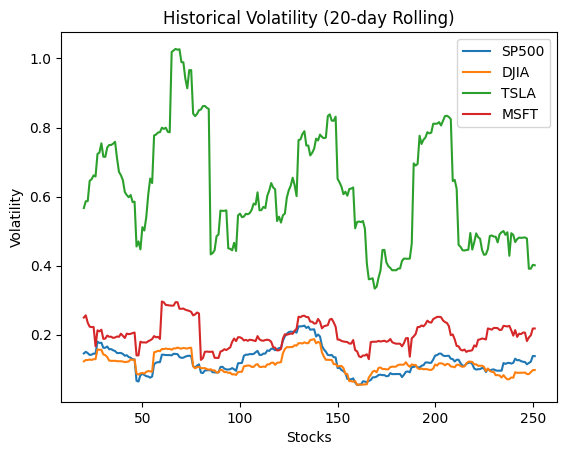

In [6]:
#plot volatility
plt.figure()
for col in volatility.columns:
    plt.plot(volatility.index, volatility[col], label=col)
plt.title("Historical Volatility (20-day Rolling)")
plt.xlabel("Stocks")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [7]:
#Gather a bit more data for the model
volatility_shifted = volatility.shift(-1) # predict next-day volatility
features = volatility.dropna()  #drop na data
target = volatility_shifted.dropna() #drop na data

#Align feature-target pairs
features, target = features.align(target, join='inner', axis=0)

# Define the split point (e.g., use the first 80% of data for training)
split_point = int(len(features) * 0.8)

# Train on past data, test on future data
X_train, X_test = features.iloc[:split_point], features.iloc[split_point:]
y_train, y_test = target.iloc[:split_point], target.iloc[split_point:]

In [8]:
#Prepare and train model
model = LinearRegression()
model.fit(X_train, y_train)

#predict and evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0005235047885857307


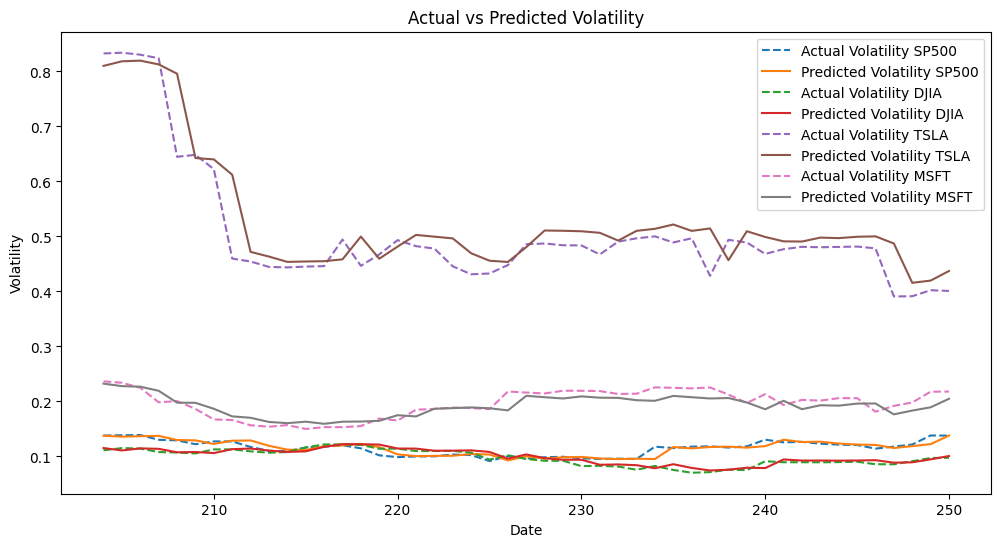

In [9]:
#ensure alignment
predictions_df = pd.DataFrame(predictions, index=y_test.index, columns=y_test.columns)

# Plot actual vs predicted volatility
plt.figure(figsize=(12, 6))
for col in y_test.columns:  # Loop over each stock column
    plt.plot(y_test.index, y_test[col], label=f'Actual Volatility {col}', linestyle='dashed')
    plt.plot(predictions_df.index, predictions_df[col], label=f'Predicted Volatility {col}')
plt.title("Actual vs Predicted Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()